# Converting RSS data into Data cubes

This notebook contains a basic explanation of the main cube interpolation methods available in PyKOLA.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pykoala import __version__
import warnings
import importlib
print("We are using pyKOALA version: ", __version__)

%load_ext autoreload
%autoreload 2

We are using pyKOALA version:  0.10.0+45.g62895a5.dirty


For this tutorial, no corrections will be applied to the data. The main focus will consist of showcasing the different cubing approaches and some intrinsic differences.

First, let us start by reading some RSS data consisting of a a set of individual exposures of the same object following a dither pattern.

In [2]:
from pykoala.instruments.koala_ifu import koala_rss

sci_rss = []
for i in [34, 35, 36]:
    filename = f"data/27feb200{i}red.fits"
    rss = koala_rss(filename)
    sci_rss.append(rss)

[Log]  Initialising history log
[Log]  Logging entry > read:- RSS read from  27feb20034red.fits
[Log]  Initialising history log
[Log]  Initialising history log
[Log]  Logging entry > read:- RSS read from  27feb20035red.fits
[Log]  Initialising history log
[Log]  Initialising history log
[Log]  Logging entry > read:- RSS read from  27feb20036red.fits
[Log]  Initialising history log


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]


As in previous tutorials, the first step is to build the WCS that will define the datacube structure. For this example, we will simply construct a datacube that uses the same spectral sampling as the RSS data, whereas for the spatial dimensions we will sample the data into a (40, 60) matrix with a pixels size of 0.5 arcseconds.

In [3]:
from pykoala.cubing import build_cube, build_wcs, build_cube
from pykoala.plotting.qc_plot import qc_cube
from pykoala.cubing import CubeStacking

# Number of pixels along the three dimensions
datacube_shape = (sci_rss[0].wavelength.size, 40, 60)
# Reference position along the three axes.
ref_position = (sci_rss[0].wavelength[0], np.mean(sci_rss[0].info['fib_ra']),
                np.mean(sci_rss[0].info['fib_dec']))  # (deg, deg)
# Spatial pixel scale size in deg
spatial_pixel_size = 0.5 / 3600
# Spectral pixel scale in angstrom
spectral_pixel_size = sci_rss[0].wavelength[1] - sci_rss[0].wavelength[0]

wcs = build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


Once we have defined the `WCS`, the next step is to define the cubing method to used to combine the RSS data. For this, there are two aspects to keep in mind. The first one is the choice of the kernel to interpolate our data along the spacial directions of the data cube. On the other hand, we need to choose how do we want to combine the information of each individual RSS after they have been sampled into a datacube. The two main objectives here are maximizin the signal to noise ratio, while keeping outliers to a minimum.

### Choosing a Kernel

The choice of an interpolation kernel and its characteristic scale depends on many factors such as:
- The number of fibres in the RSS data
- The number of individual exposures (RSS) to combine.
- The projected size of the fibres
- The pixel size of the output datacube.
- The seeing of the observations

Unfortunately, there is no general rule when it comes to chosing a particular interpolation scheme. Regardless of the kernel shape, its scale should always range around the fibre size or the seeing of the night. The more individual exposures we have available to combine, the smaller the scale can be in order to recover more structure.

In PyKOALA, there are available a series of interpolation kernels that can be used to combine RSS exposures. All kernels are defined by `scale` parameter, which represents the spatial extent to which individual fibres contribute to the datacube grid of spaxels. When the kernel function extends to infinity (e.g. a Gaussian), it is also possible to define a `truncation_radius`, which prevents the data to be interpolated over the whole datacube (minimizing the resultant covariance between the pixels).

In the example below, we will define four kernels:
- A Gaussian (`GaussianKernel`).
- A parabolic or Epanechnikov kernel (`ParabolicKernel`).
- A Top Hat kernel (`TopHat`).
- A Drizzling kernel (`DrizzlingKernel`).

The latter enables to perform the traditional drizzling algorithm (which can be interpreted as an interpolation using a Top Hat kernel). In particular, this algorithm consists of defining a set of input pixels, shrinking them by a given scale, and then including them in the final datacube grid accounting for the overlapping fraction of between the input and target pixels. To date, this algorithm assumes that the input RSS fibres are circular, and computes the overlap fraction of the circular fibre aperture with the square pixels of the datacube.

Now, let's have a look at their functional form along in one dimension.

In [4]:
from pykoala.cubing import GaussianKernel, ParabolicKernel, TopHatKernel, DrizzlingKernel

pixel_scale = 0.7
truncation_radius = 2.0
gauss_kernel = GaussianKernel(scale=pixel_scale, truncation_radius=truncation_radius)
epanechikov_kernel = ParabolicKernel(scale=pixel_scale)  # This kernel's domain is confined within +/-1
tophat_kernel = TopHatKernel(scale=pixel_scale, truncation_radius=truncation_radius)

The `truncation radius` is expressed in units of the `scale`. In other words, if our characteristic scale is 0.7 pixels, and our truncation radius is 2, then the pixels laying beyond 1.4 pixels with respect to the kernel centre will have a null weight.

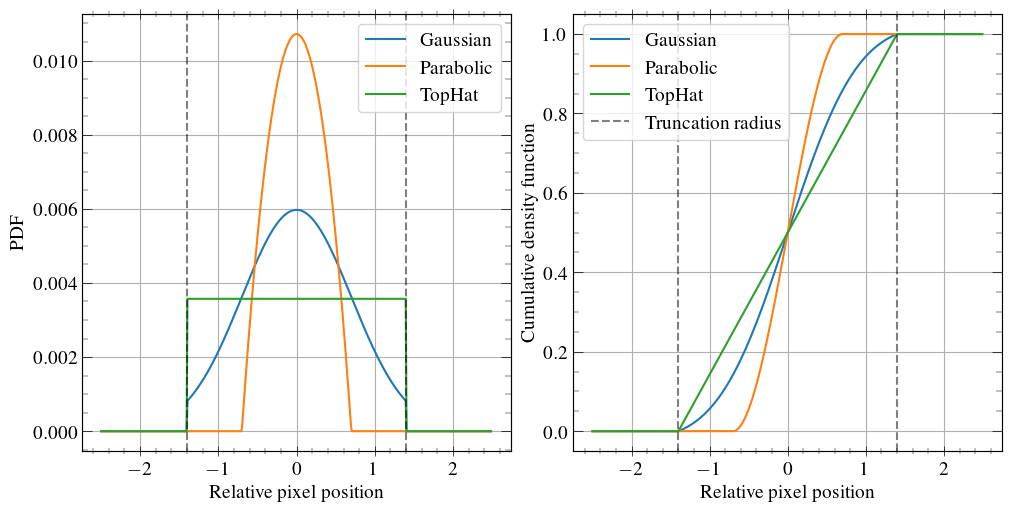

In [5]:

dummy_pixel_edges = np.arange(-2.5, 2.5, 0.01)

dummy_pixel_bins = (dummy_pixel_edges[:-1] + dummy_pixel_edges[1:]) / 2

plt.figure(figsize=(10, 5), constrained_layout=True)
plt.subplot(121)
plt.plot(dummy_pixel_bins, gauss_kernel.kernel_1D(dummy_pixel_edges), label='Gaussian')
plt.plot(dummy_pixel_bins, epanechikov_kernel.kernel_1D(dummy_pixel_edges), label='Parabolic')
plt.plot(dummy_pixel_bins, tophat_kernel.kernel_1D(dummy_pixel_edges), label='TopHat')
plt.axvline(-pixel_scale * truncation_radius, color='k',  ls='--', alpha=0.5)
plt.axvline(pixel_scale * truncation_radius, color='k',  ls='--', alpha=0.5)
plt.legend()
plt.xlabel('Relative pixel position')
plt.ylabel('PDF')
plt.subplot(122)
plt.plot(dummy_pixel_edges, gauss_kernel.cmf(dummy_pixel_edges / 0.7), label='Gaussian')
plt.plot(dummy_pixel_edges, epanechikov_kernel.cmf(dummy_pixel_edges / 0.7), label='Parabolic')
plt.plot(dummy_pixel_edges, tophat_kernel.cmf(dummy_pixel_edges / 0.7), label='TopHat')
plt.axvline(-pixel_scale * truncation_radius, color='k',  ls='--', alpha=0.5)
plt.axvline(pixel_scale * truncation_radius, color='k',  ls='--', alpha=0.5, label='Truncation radius')
plt.xlabel('Relative pixel position')
plt.ylabel('Cumulative density function')
plt.legend()


#### Chosing the stacking method

In addition to the kernel, we must also decide how do we want to combine the individual exposures (in case there is more than one) into the final data cube. For this PyKOALA currently provides two flavours:
- sigma clipping
- MAD clipping

For more information see the documentation of `CubeStacking` and its methods.

If you want to use you own stacking method, you can implement a function that takes as its two first arguments a list of datacubes (3D arrays), and a list of variances (idem), followed by keyword arguments and returns the combined cube and variance.

Finally, let us combine the RSS data into a datacube using different interpolation kernels. For each kernel, we will use the method `build_cube`, which will return a `pykoala.cubing.Cube` object, and a dictionary containing several QC plots (exposure time maps and fibre coverage).

Building cube using kernel:  DrizzlingKernel
[Cubing] Starting cubing process
[Cubing] Initialising DrizzlingKernel
 Scale: 4.0 (pixels)
 Truncation radius: 1.0
[Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
Mean exposure time:  217.1444545409239
[Cubing] Stacking individual cubes using mad_clipping
[Cubing] Additonal arguments for stacking: {}


/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:58: RuntimeWarning: divide by zero encountered in divide
  (cubes - median[np.newaxis]) / sigma[np.newaxis]) < nsigma
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:58: RuntimeWarning: invalid value encountered in divide
  (cubes - median[np.newaxis]) / sigma[np.newaxis]) < nsigma
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:61: RuntimeWarning: divide by zero encountered in divide
  w = 1 / variances
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:65: RuntimeWarning: invalid value encountered in multiply
  stacked_cube = np.nansum(cubes * w * good_pixel, axis=0) / np.nansum(
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:66: RuntimeWarning: invalid value encountered in multiply
  w * good_pixel, axis=0)
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:65: RuntimeWarning: invalid value encountered in divide
  stacked_cube = np.nansum(cubes * w * good_pixel, axis=0) / np.nansum(


[Cube] Initialising cube from input HDUL
[Cube] Reading WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Log]  Initialising history log
[Cube] Looking for information in the primary header
[Cube] Constructing wavelength array
Building cube using kernel:  ParabolicKernel
[Cubing] Starting cubing process
[Cubing] Initialising ParabolicKernel
 Scale: 4.0 (pixels)
 Truncation radius: 1.0
[Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
Mean exposure time:  216.55939681234727
[Cubing] Stacking individual cubes using mad_clipping
[Cubing] Additonal arguments for stacking: {}


/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:58: RuntimeWarning: divide by zero encountered in divide
  (cubes - median[np.newaxis]) / sigma[np.newaxis]) < nsigma
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:58: RuntimeWarning: invalid value encountered in divide
  (cubes - median[np.newaxis]) / sigma[np.newaxis]) < nsigma
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:61: RuntimeWarning: divide by zero encountered in divide
  w = 1 / variances
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:65: RuntimeWarning: invalid value encountered in multiply
  stacked_cube = np.nansum(cubes * w * good_pixel, axis=0) / np.nansum(
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:66: RuntimeWarning: invalid value encountered in multiply
  w * good_pixel, axis=0)
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:65: RuntimeWarning: invalid value encountered in divide
  stacked_cube = np.nansum(cubes * w * good_pixel, axis=0) / np.nansum(


[Cube] Initialising cube from input HDUL
[Cube] Reading WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Log]  Initialising history log
[Cube] Looking for information in the primary header
[Cube] Constructing wavelength array
Building cube using kernel:  GaussianKernel
[Cubing] Starting cubing process
[Cubing] Initialising GaussianKernel
 Scale: 4.0 (pixels)
 Truncation radius: 1.0
[Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
Mean exposure time:  216.01562254378865
[Cubing] Stacking individual cubes using mad_clipping
[Cubing] Additonal arguments for stacking: {}


/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:58: RuntimeWarning: divide by zero encountered in divide
  (cubes - median[np.newaxis]) / sigma[np.newaxis]) < nsigma
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:58: RuntimeWarning: invalid value encountered in divide
  (cubes - median[np.newaxis]) / sigma[np.newaxis]) < nsigma
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:61: RuntimeWarning: divide by zero encountered in divide
  w = 1 / variances
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:65: RuntimeWarning: invalid value encountered in multiply
  stacked_cube = np.nansum(cubes * w * good_pixel, axis=0) / np.nansum(
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:66: RuntimeWarning: invalid value encountered in multiply
  w * good_pixel, axis=0)
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:65: RuntimeWarning: invalid value encountered in divide
  stacked_cube = np.nansum(cubes * w * good_pixel, axis=0) / np.nansum(


[Cube] Initialising cube from input HDUL
[Cube] Reading WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Log]  Initialising history log
[Cube] Looking for information in the primary header
[Cube] Constructing wavelength array


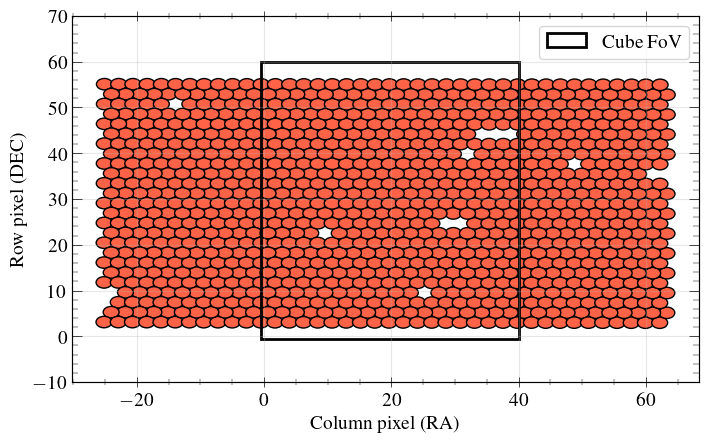

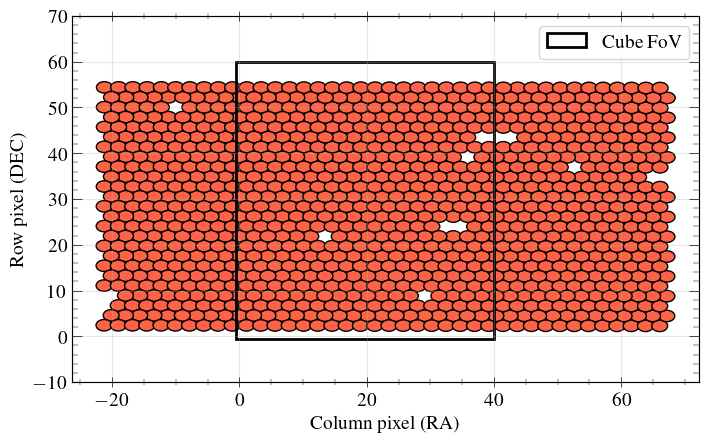

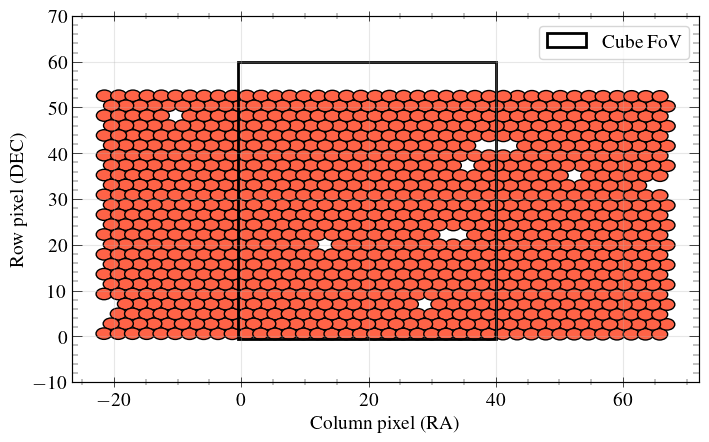

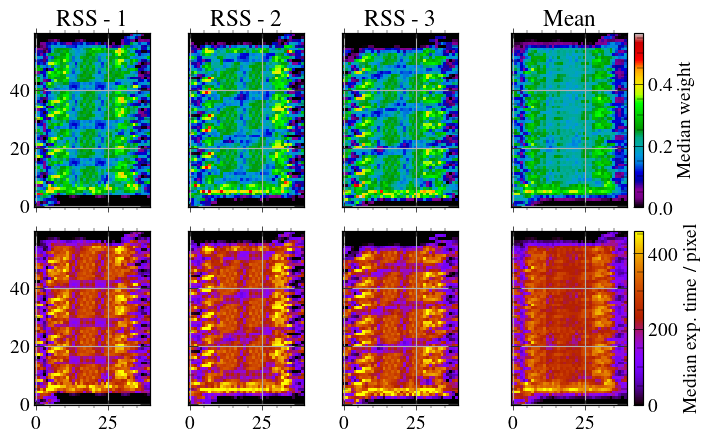

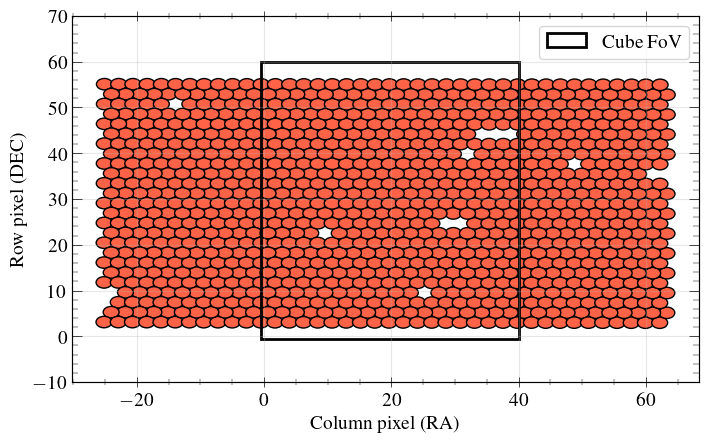

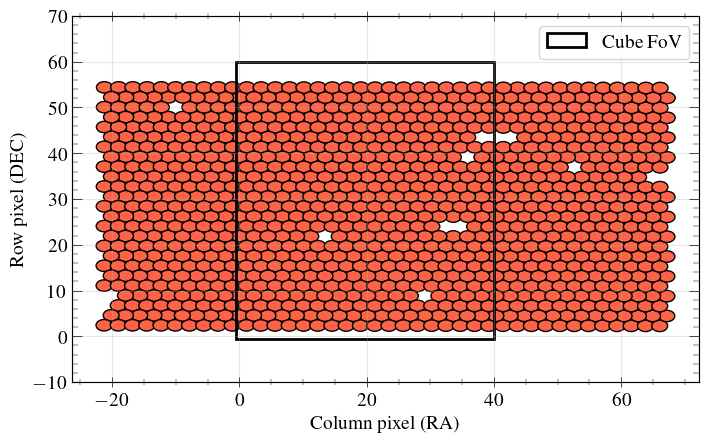

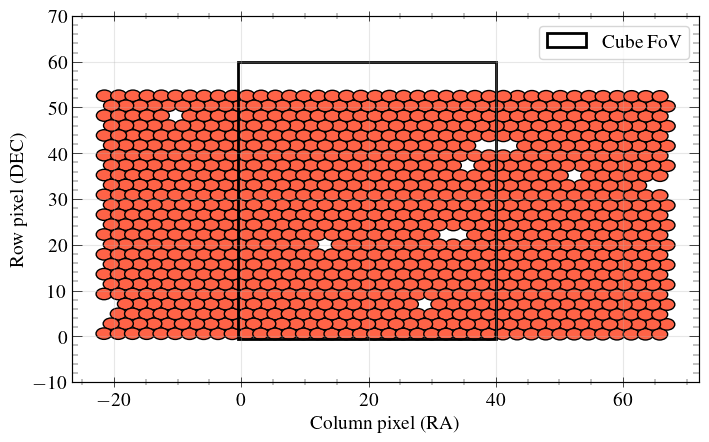

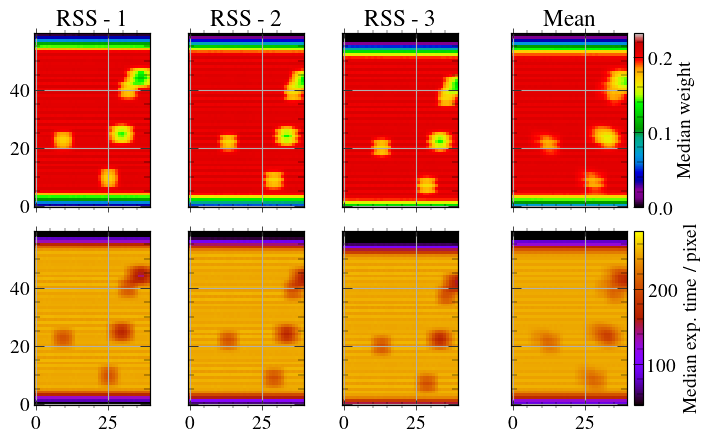

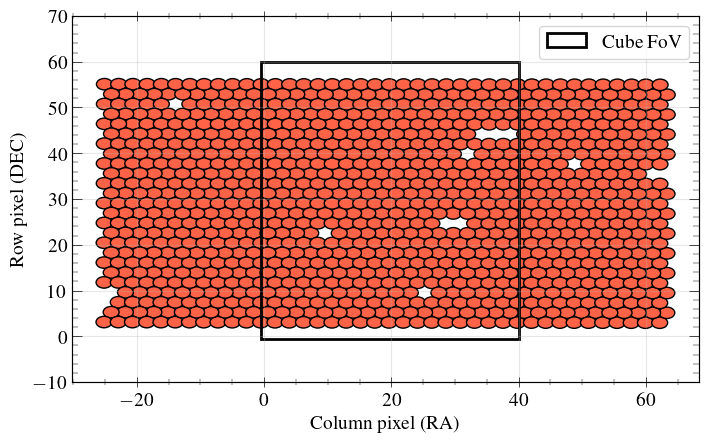

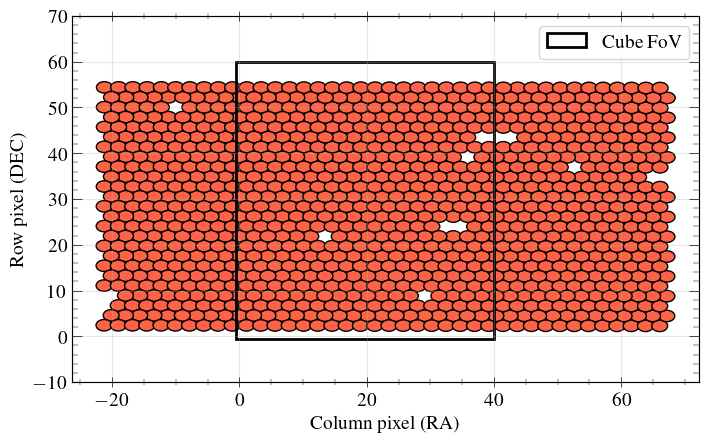

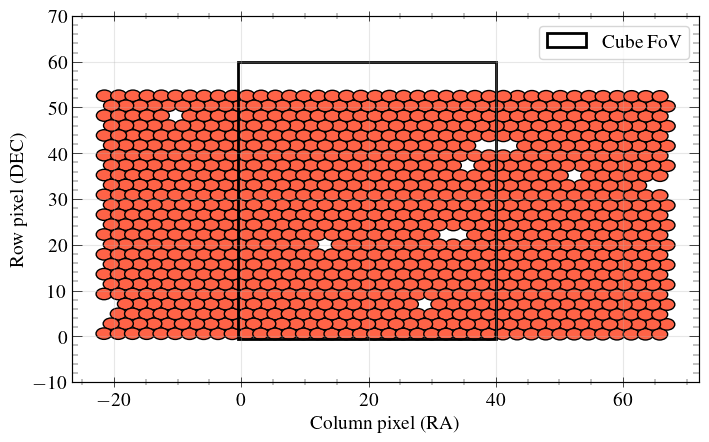

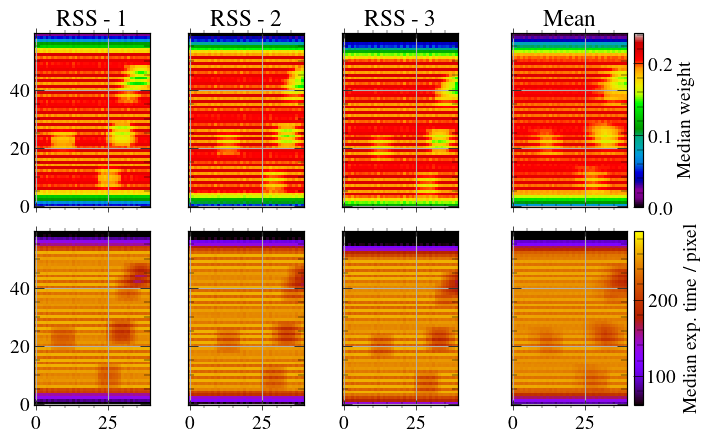

In [6]:
all_cubes = []
for kernel in [DrizzlingKernel, ParabolicKernel, GaussianKernel]:
    print("Building cube using kernel: ", kernel.__name__)
    new_cube, plots = build_cube(rss_set=sci_rss,
                            wcs=wcs,
                            kernel=kernel,
                            kernel_size_arcsec=2.0,
                            kernel_truncation_radius=1,
                            qc_plots=True)
    all_cubes.append(new_cube)
    
    plt.figure(plots['rss_1'])
    plt.figure(plots['weights'])


Let us now have a look at the differences between the different cubing methods

/tmp/ipykernel_6534/3473640066.py:11: RuntimeWarning: divide by zero encountered in log10
  mappable = ax.imshow(np.log10(all_cubes[i].intensity[wl_idx]), **im_args)
/tmp/ipykernel_6534/3473640066.py:14: RuntimeWarning: divide by zero encountered in log10
  mappable = ax.imshow(np.log10(all_cubes[i].intensity[wl_idx]


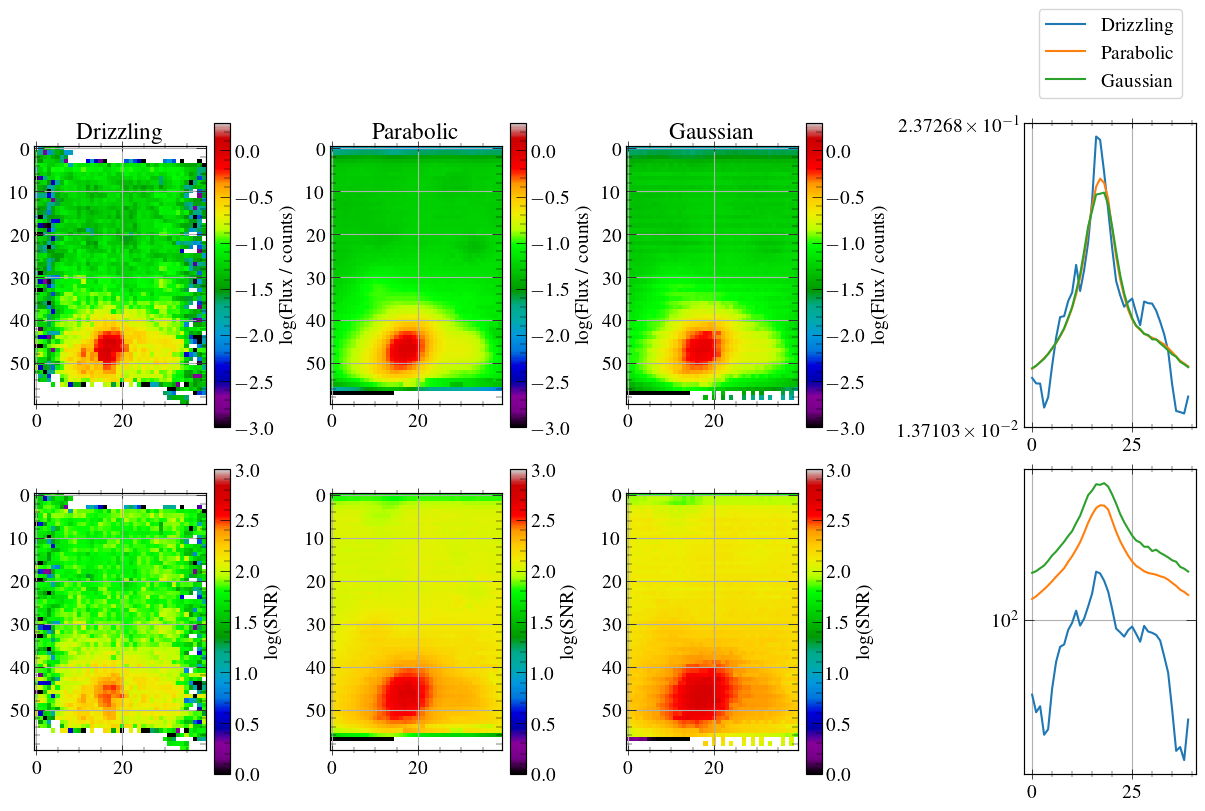

In [8]:
wl_idx = 400

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8), constrained_layout=True)
im_args = dict(vmax=0.3, vmin=-3, interpolation='none', cmap='nipy_spectral')
snr_args = dict(vmax=3, vmin=0, interpolation='none', cmap='nipy_spectral')

names = ['Drizzling', 'Parabolic', 'Gaussian']
for i in range(3):
    ax = axs[0, i]
    ax.set_title(names[i])
    mappable = ax.imshow(np.log10(all_cubes[i].intensity[wl_idx]), **im_args)
    plt.colorbar(mappable, ax=ax, label='log(Flux / counts)')
    ax = axs[1, i]
    mappable = ax.imshow(np.log10(all_cubes[i].intensity[wl_idx]
                       / all_cubes[i].variance[wl_idx]**0.5), **snr_args)
    plt.colorbar(mappable, ax=ax, label='log(SNR)')

    ax = axs[0, -1]
    ax.plot(np.nanmean(all_cubes[i].intensity[wl_idx], axis=0), label=names[i])
    ax = axs[1, -1]
    ax.plot(
        np.nanmean(all_cubes[i].intensity[wl_idx], axis=0
                  ) / np.nanmean(all_cubes[i].variance[wl_idx], axis=0)**0.5)

axs[0, -1].set_yscale('symlog')
axs[0, -1].legend(bbox_to_anchor=(0.5, 1.05), loc='lower center')
axs[1, -1].set_yscale('symlog')